In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [170]:
path = '.\\data_udp_tcp\\'

In [171]:
colnames = pd.read_csv('NUSW-NB15_features.csv', sep=',', index_col=False, dtype='unicode')
df = pd.read_csv('UNSW-NB15_1.csv', sep=',', index_col=False, dtype='unicode', header = None, names = colnames['Name'])
df.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.9375,621800.9375,2,2,0,0,0,0,66,82,0,0,0,0,1421927414,1421927414,0.017,0.013,0,0,0,0,0,0,0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0,0,0,0,0,0,0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.5313,636282.375,2,2,0,0,0,0,73,89,0,0,0,0,1421927414,1421927414,0.017,0.013,0,0,0,0,0,0,0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.5625,542597.1875,2,2,0,0,0,0,66,82,0,0,0,0,1421927414,1421927414,0.043,0.014,0,0,0,0,0,0,0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25,609067.5625,2,2,0,0,0,0,73,89,0,0,0,0,1421927414,1421927414,0.005,0.003,0,0,0,0,0,0,0,0,7,9,1,1,1,1,1,NaN,0


In [172]:
first_dim = df[df['proto'] == 'udp']
first_dim = first_dim[['proto', 'sport', 'srcip', 'dsport', 'dstip', 'Spkts', 'Dpkts', 'sbytes', 'dbytes', 'Stime', 'Ltime', 'attack_cat', 'Label']]
first_dim = first_dim.astype({'sport':'int', 'dsport':'int', 'Spkts':'int', 'Dpkts':'int', 'sbytes':'int', 'dbytes':'int', 'Ltime':'int', 'Stime':'int', 'Label':'int'})#['dsport'].astype(int)


<Axes: xlabel='attack_cat'>

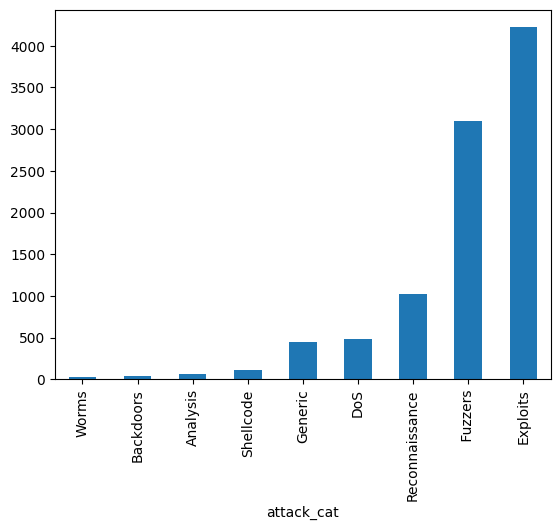

In [173]:
df[df['proto'] == 'tcp']['attack_cat'].value_counts().sort_values().plot(kind='bar', ) 

<Axes: xlabel='attack_cat'>

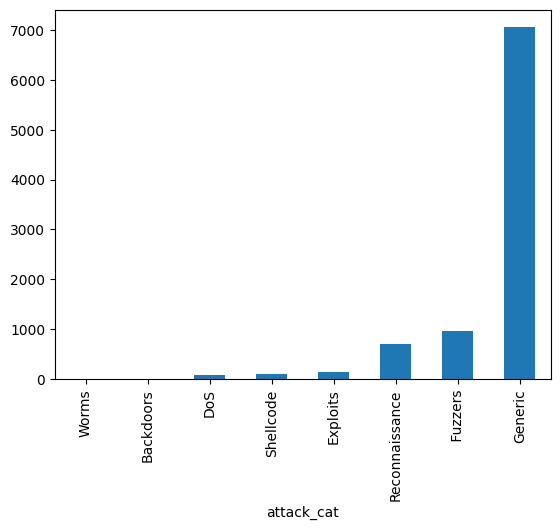

In [174]:
df[df['proto'] == 'udp']['attack_cat'].value_counts().sort_values().plot(kind='bar') 

In [175]:
delta = 1

In [176]:
first_dim['time_slot'] = [0 for i in range(len(first_dim))]
start = min(first_dim['Stime'])
end = max(first_dim['Stime'])
for time_slot in range(start, end + 1, delta):
    first_dim.loc[(first_dim['Stime'] >= time_slot) & (first_dim['Stime'] < time_slot +  delta), 'time_slot'] = time_slot
good_data = first_dim[first_dim['attack_cat'].isna()]
bad_data = first_dim[first_dim['attack_cat'].isna() == False]
bad_data.head()

,proto,sport,srcip,dsport,dstip,Spkts,Dpkts,sbytes,dbytes,Stime,Ltime,attack_cat,Label,time_slot
20,udp,21223,175.45.176.3,32780,149.171.126.18,2,0,728,0,1421927415,1421927415,Exploits,1,1421927415
110,udp,22359,175.45.176.3,111,149.171.126.11,2,0,168,0,1421927426,1421927426,Reconnaissance,1,1421927426
242,udp,55249,175.45.176.3,5060,149.171.126.10,2,0,1388,0,1421927441,1421927441,Generic,1,1421927441
246,udp,36159,175.45.176.0,111,149.171.126.14,2,0,168,0,1421927442,1421927442,Reconnaissance,1,1421927442
600,udp,29442,175.45.176.2,111,149.171.126.19,2,0,168,0,1421927445,1421927445,Reconnaissance,1,1421927445


Подсчет энтропии для ip-фдркса источника (подсчет для количества пакетов)

In [177]:
from datetime import datetime
from scipy import stats
def entropy_my(first_dim):
    entropy_data = {}
    entropy_sum = {}
    threats = {}
    for data in first_dim.iterrows():
        row = data[1]
        if row['time_slot'] in entropy_data.keys():
            if row['srcip'] in entropy_data[row['time_slot']].keys():
                entropy_data[row['time_slot']][row['srcip']] += row['Spkts']
            else:
                entropy_data[row['time_slot']][row['srcip']] = row['Spkts']
        else:
            entropy_data[row['time_slot']] = entropy_data[row['time_slot']]= {}
            entropy_data[row['time_slot']][row['srcip']] = row['Spkts']
    for key in entropy_data.keys():
        for k in entropy_data[key].keys():
            entropy_data[key][k] /= sum(entropy_data[key].values())
    counted_entropy = {}
    for key in entropy_data.keys():
        counted_entropy[key] = stats.entropy(np.array(list(entropy_data[key].values())))
    return counted_entropy


In [178]:
data_temp_good = entropy_my(good_data)
data_temp_good

{1421927414: 1.3753332951746553,
 1421927415: 1.3116329624005534,
 1421927416: 1.9581796858739529,
 1421927417: 1.5425119988838956,
 1421927418: 1.7142572850648503,
 1421927419: 1.3076747562161524,
 1421927420: 1.4643822458135174,
 1421927421: 1.3754691136317703,
 1421927422: 1.6903546776014935,
 1421927423: 1.5469090355307649,
 1421927424: 1.3076747562161524,
 1421927425: 0.6866136204854095,
 1421927426: 1.2867319929138796,
 1421927427: 1.5694120001002172,
 1421927428: 1.5641473662821324,
 1421927429: 1.314771391685432,
 1421927430: 1.4125766280589567,
 1421927431: 1.4409442575277267,
 1421927432: 1.8336347768824937,
 1421927433: 1.556755350812256,
 1421927434: 1.515867417040809,
 1421927435: 1.0929441879164323,
 1421927436: 1.081921636796234,
 1421927437: 1.3160971352000357,
 1421927438: 1.485081330920817,
 1421927439: 1.6903546776014935,
 1421927440: 1.4542288339811276,
 1421927441: 1.4562897198613753,
 1421927442: 1.049657461003257,
 1421927443: 1.5483871644782747,
 1421927444: 1.3

In [179]:
data = [[datetime.fromtimestamp(timestamp), data_temp_good[timestamp]] for timestamp in data_temp_good.keys()]
df_res = pd.DataFrame(data, columns = ['date', 'entropy'], index=None)
df_res.set_index('date', inplace=True, drop=True)
df_res

,entropy
date,
2015-01-22 14:50:14,1.375333
2015-01-22 14:50:15,1.311633
2015-01-22 14:50:16,1.958180
2015-01-22 14:50:17,1.542512
2015-01-22 14:50:18,1.714257
...,...
2015-01-22 22:43:58,1.519105
2015-01-22 22:43:59,1.332435
2015-01-22 22:44:00,1.318013


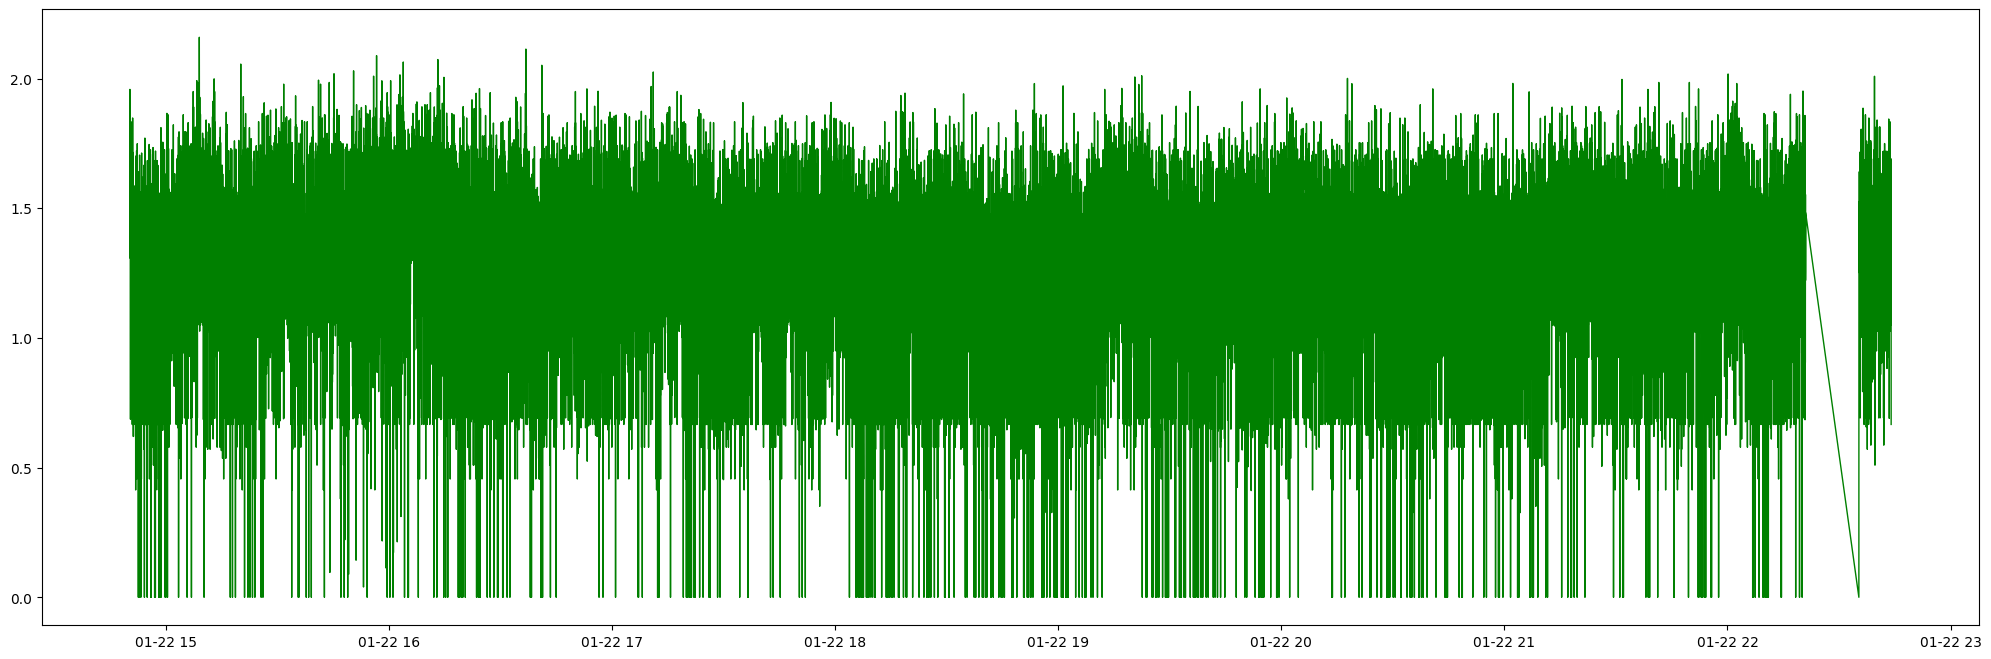

In [180]:
plt.figure(figsize = (25,8))
plt.plot(df_res.index, df_res['entropy'], color='green', linewidth=1)

In [181]:
data_temp_bad = entropy_my(bad_data)
data_temp_bad

{1421927415: 0.0,
 1421927426: 0.0,
 1421927441: 0.0,
 1421927442: 0.0,
 1421927445: 0.0,
 1421927449: 0.666278442414676,
 1421927458: 0.0,
 1421927459: 0.0,
 1421927462: 0.0,
 1421927466: 0.0,
 1421927480: 0.0,
 1421927483: 0.0,
 1421927485: 0.0,
 1421927486: 0.0,
 1421927498: 0.0,
 1421927504: 0.0,
 1421927509: 0.0,
 1421927516: 0.0,
 1421927518: 0.0,
 1421927520: 0.0,
 1421927524: 0.0,
 1421927528: 0.0,
 1421927531: 0.0,
 1421927547: 0.0,
 1421927549: 0.0,
 1421927554: 0.0,
 1421927555: 0.0,
 1421927560: 0.0,
 1421927580: 0.0,
 1421927582: 0.0,
 1421927590: 0.0,
 1421927600: 0.0,
 1421927611: 0.0,
 1421927612: 0.0,
 1421927620: 0.0,
 1421927629: 0.0,
 1421927632: 0.0,
 1421927635: 0.0,
 1421927636: 0.0,
 1421927641: 0.0,
 1421927663: 0.0,
 1421927667: 0.0,
 1421927670: 0.0,
 1421927673: 0.0,
 1421927675: 0.0,
 1421927677: 0.0,
 1421927688: 0.0,
 1421927689: 0.0,
 1421927691: 0.0,
 1421927703: 0.0,
 1421927704: 0.0,
 1421927705: 0.5785341056326687,
 1421927706: 0.6914160776171183,
 1

In [182]:
data_bad = [[datetime.fromtimestamp(timestamp), data_temp_bad[timestamp]] for timestamp in data_temp_bad.keys()]
df_res_bad = pd.DataFrame(data_bad, columns = ['date', 'entropy'], index=None)
df_res_bad.set_index('date', inplace=True, drop=True)
df_res_bad

,entropy
date,
2015-01-22 14:50:15,0.0
2015-01-22 14:50:26,0.0
2015-01-22 14:50:41,0.0
2015-01-22 14:50:42,0.0
2015-01-22 14:50:45,0.0
...,...
2015-01-22 16:45:41,0.0
2015-01-22 16:45:43,0.0
2015-01-22 16:45:55,0.0


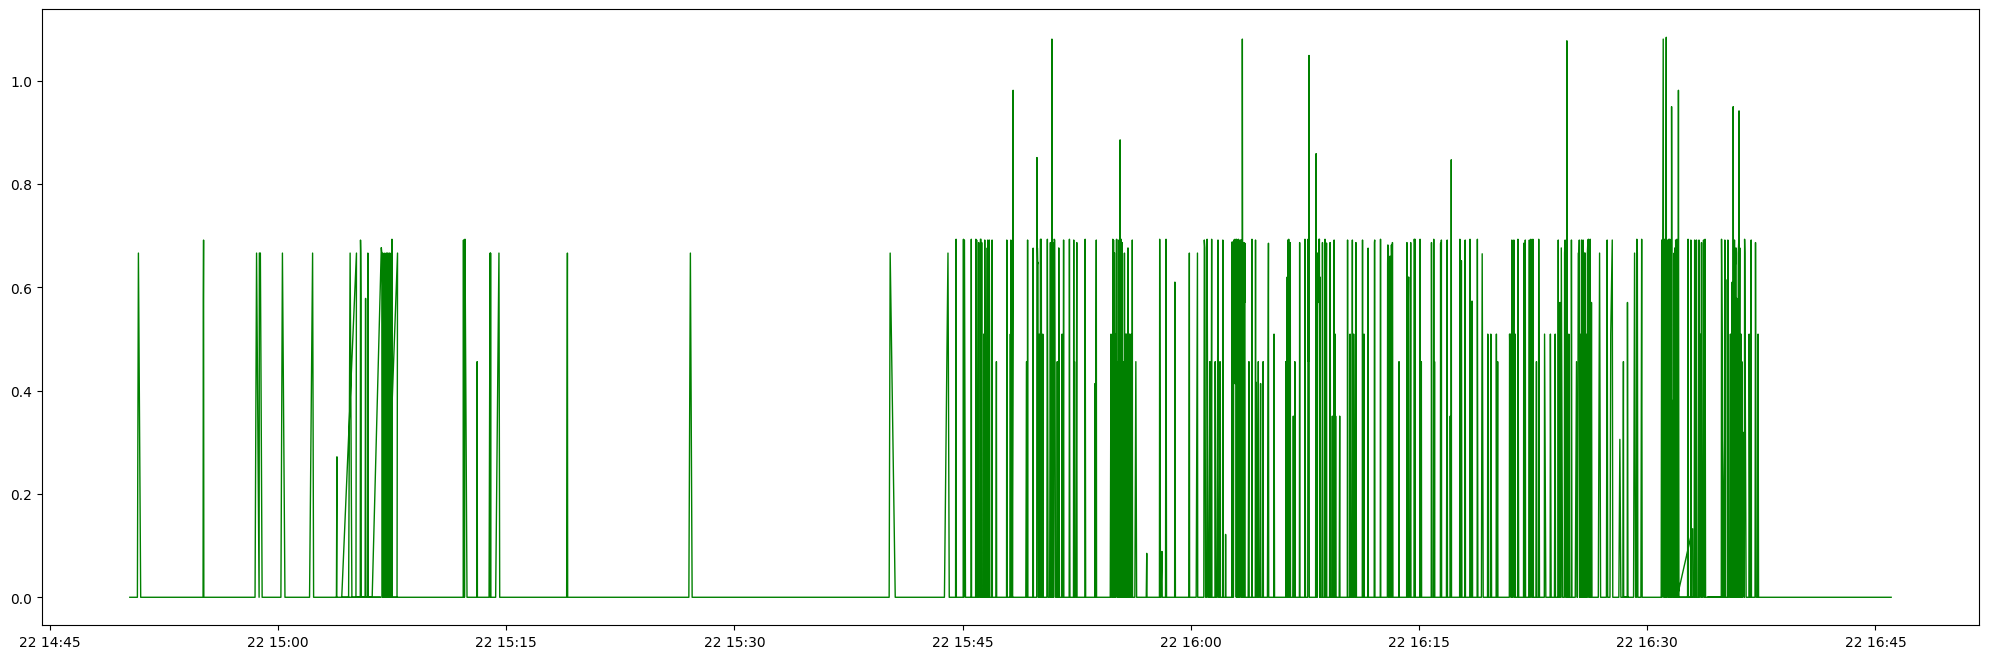

In [183]:
plt.figure(figsize = (25,8))
plt.plot(df_res_bad.index, df_res_bad['entropy'], color='green', linewidth=1)

In [184]:
df_res_bad['color'] = ['red' for i in range(len(data_temp_bad))]
df_res['color'] = ['green' for i in range(len(data_temp_good))]
result = pd.concat([df_res, df_res_bad])
result

,entropy,color
date,,
2015-01-22 14:50:14,1.375333,green
2015-01-22 14:50:15,1.311633,green
2015-01-22 14:50:16,1.958180,green
2015-01-22 14:50:17,1.542512,green
2015-01-22 14:50:18,1.714257,green
...,...,...
2015-01-22 16:45:41,0.000000,red
2015-01-22 16:45:43,0.000000,red
2015-01-22 16:45:55,0.000000,red


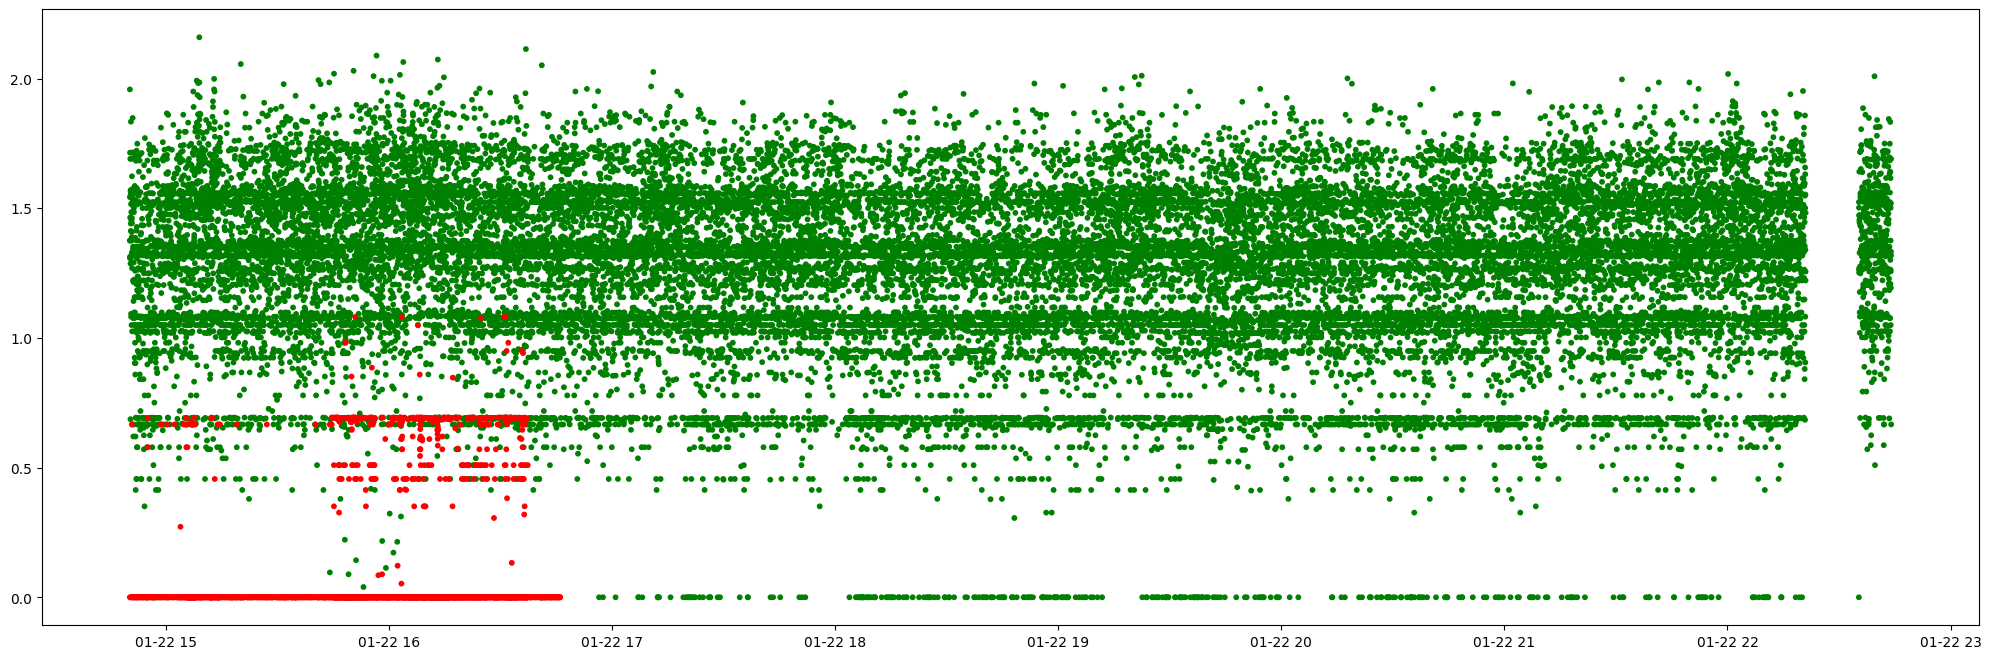

In [187]:
plt.figure(figsize = (25,8))
plt.scatter(result.index, result['entropy'], c=result['color'], s = 10)